<a href="https://colab.research.google.com/github/tncourtz/RL-EV-CS-Energy-Management-System/blob/main/DNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import datetime
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Model, Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
from pandas.tseries.offsets import DateOffset

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, files
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
from google.colab import files
uploaded = files.upload()

Saving shampoo.csv to shampoo.csv


In [4]:
import io
df = pd.read_csv(io.BytesIO(uploaded['shampoo.csv']))

In [5]:
print(df.head())

  Month  Sales
0  1-01  266.0
1  1-02  145.9
2  1-03  183.1
3  1-04  119.3
4  1-05  180.3


In [22]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas import concat
from pandas import Series
import math 
import random
import progressbar
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
from pandas.tseries.offsets import DateOffset
from IPython.display import clear_output
from collections import deque

def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return Series(diff)

def invert_scale(scaler, X, value):
  new_row = [x for x in X] + [value]
  array = np.array(new_row)
  array = array.reshape(1, len(array))
  inverted = scaler.inverse_transform(array)
  return inverted[0, -1]
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# load dataset
def parser(x):
	return pd.to_datetime('190'+x, format='%Y-%m', errors='ignore')
 
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

def forecast(model, batch_size, row):
	X = row[0:-1]
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]


In [7]:
from google.colab import files
uploaded = files.upload()

Saving Prices2.csv to Prices2.csv


Hour=1, Predicted=-0.010792, Expected=0.002180
Hour=2, Predicted=-0.007237, Expected=0.005810
Hour=3, Predicted=0.006609, Expected=0.006000
Hour=4, Predicted=0.022326, Expected=0.014100
Hour=5, Predicted=0.028484, Expected=0.018440
Hour=6, Predicted=0.013619, Expected=0.016550
Hour=7, Predicted=0.014516, Expected=0.016030
Hour=8, Predicted=0.013599, Expected=0.019690
Hour=9, Predicted=0.020087, Expected=0.017140
Hour=10, Predicted=0.019495, Expected=0.011980
Hour=11, Predicted=0.013519, Expected=0.008680
Hour=12, Predicted=0.006730, Expected=0.010320
Test RMSE: 0.007


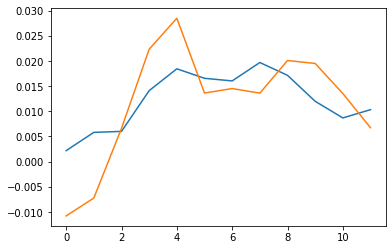

         0        0
0  0.00000 -0.01306
1 -0.01306 -0.00490
2 -0.00490 -0.00422
3 -0.00422  0.00224
4  0.00224 -0.00746


In [8]:
df = read_csv('Prices2.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
#transform data to stationary 
raw_values = df.values
diff_values = difference(raw_values, 1)
#transofrm data to be supervised learning  
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 1500, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()

for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Hour=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
 
# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()
print(supervised.head())

In [10]:
from google.colab import files
uploaded = files.upload()

Saving Prices2.csv to Prices2 (1).csv


Hour=1, Predicted=-0.001007, Expected=0.002180
Hour=2, Predicted=0.001039, Expected=0.005810
Hour=3, Predicted=0.005915, Expected=0.006000
Hour=4, Predicted=0.005258, Expected=0.014100
Hour=5, Predicted=0.019456, Expected=0.018440
Hour=6, Predicted=0.011085, Expected=0.016550
Hour=7, Predicted=0.018024, Expected=0.016030
Hour=8, Predicted=0.014109, Expected=0.019690
Hour=9, Predicted=0.023858, Expected=0.017140
Hour=10, Predicted=0.015669, Expected=0.011980
Hour=11, Predicted=0.015499, Expected=0.008680
Hour=12, Predicted=0.007434, Expected=0.010320
Test RMSE: 0.005


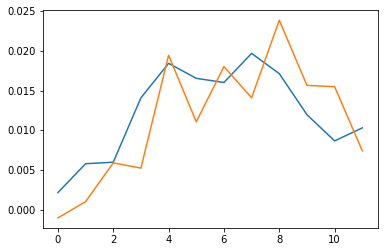

         0        0
0  0.00000 -0.01306
1 -0.01306 -0.00490
2 -0.00490 -0.00422
3 -0.00422  0.00224
4  0.00224 -0.00746


In [11]:
df = read_csv('Prices2.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
#transform data to stationary 
raw_values = df.values
diff_values = difference(raw_values, 1)
#transofrm data to be supervised learning  
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 1500, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()

for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Hour=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
 
# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()
print(supervised.head())

In [80]:
from google.colab import files
uploaded = files.upload()

Saving trr.csv to trr (8).csv


In [82]:
df = read_csv('trr (8).csv', header=0, parse_dates=[0], index_col=0)

In [83]:
model = Sequential()
model.add(LSTM(180, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator, epochs=180)

Epoch 1/180
44/44 [==============================] - 1s 23ms/step - loss: 0.1059
Epoch 2/180
44/44 [==============================] - 1s 24ms/step - loss: 0.0364
Epoch 3/180
44/44 [==============================] - 1s 23ms/step - loss: 0.0392
Epoch 4/180
44/44 [==============================] - 1s 24ms/step - loss: 0.0412
Epoch 5/180
44/44 [==============================] - 1s 23ms/step - loss: 0.0327
Epoch 6/180
44/44 [==============================] - 1s 22ms/step - loss: 0.0387
Epoch 7/180
44/44 [==============================] - 1s 23ms/step - loss: 0.0343
Epoch 8/180
44/44 [==============================] - 1s 26ms/step - loss: 0.0303
Epoch 9/180
44/44 [==============================] - 1s 24ms/step - loss: 0.0348
Epoch 10/180
44/44 [==============================] - 1s 23ms/step - loss: 0.0308
Epoch 11/180
44/44 [==============================] - 1s 25ms/step - loss: 0.0293
Epoch 12/180
44/44 [==============================] - 1s 27ms/step - loss: 0.0354
Epoch 13/180
44/44 [=====

In [89]:
n_input = 24
n_features = 1
train = df
scaler.fit(train)
train = scaler.transform(train)
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=5)

model.fit_generator(generator, epochs=1000)
prediction_list = []
batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):
    prediction_list.append(model.predict(batch)[0])
    batch = np.append(batch[:, 1:, :], [[prediction_list[i]]], axis=1)

Epoch 1/1000
44/44 [==============================] - 1s 25ms/step - loss: 0.0191
Epoch 2/1000
44/44 [==============================] - 1s 26ms/step - loss: 0.0187
Epoch 3/1000
44/44 [==============================] - 1s 25ms/step - loss: 0.0187
Epoch 4/1000
44/44 [==============================] - 1s 24ms/step - loss: 0.0193
Epoch 5/1000
44/44 [==============================] - 1s 25ms/step - loss: 0.0193
Epoch 6/1000
44/44 [==============================] - 1s 26ms/step - loss: 0.0190
Epoch 7/1000
44/44 [==============================] - 1s 24ms/step - loss: 0.0187
Epoch 8/1000
44/44 [==============================] - 1s 23ms/step - loss: 0.0188
Epoch 9/1000
44/44 [==============================] - 1s 24ms/step - loss: 0.0185
Epoch 10/1000
44/44 [==============================] - 1s 24ms/step - loss: 0.0189
Epoch 11/1000
44/44 [==============================] - 1s 24ms/step - loss: 0.0187
Epoch 12/1000
44/44 [==============================] - 1s 25ms/step - loss: 0.0196
Epoch 13/1000

In [90]:
print(df.index[-1])

2020-09-12 23:00:00


In [91]:
add_dates = [df.index[-1] + DateOffset(hours=x) for x in range(0, 25)]
future_dates = pd.DataFrame(index=add_dates[1:], columns=df.columns)

In [92]:
df_prediction = pd.DataFrame(scaler.inverse_transform(prediction_list), index=future_dates[-n_input:].index, columns=['prediction'])
df_proj = pd.concat([df, df_prediction], axis=1)

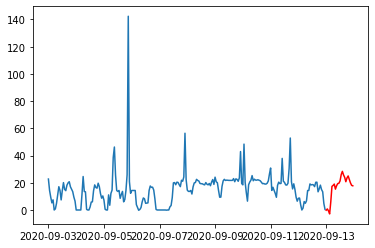

In [93]:
pyplot.plot(df_proj.index, df_proj['power'], label='original')
pyplot.plot(df_proj.index, df_proj['prediction'], color='red', label='prediction')
pyplot.show()